# LAB 2 

In [138]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import urllib.request
from sklearn.linear_model import LinearRegression
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, train_test_split,  cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, auc, roc_curve
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans


Read data from csv and get field info

In [2]:

sdata = pd.read_csv("data/StudentsPerformance.csv")
sdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Not much pre-processing needed here, perhaps just some binning as there are no missing records.

In [3]:
sdata["gender"].value_counts()

female    518
male      482
Name: gender, dtype: int64

About 36 more females in our data, which could lead to a slight bias when providing any broad conclusions

In [4]:
sdata.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


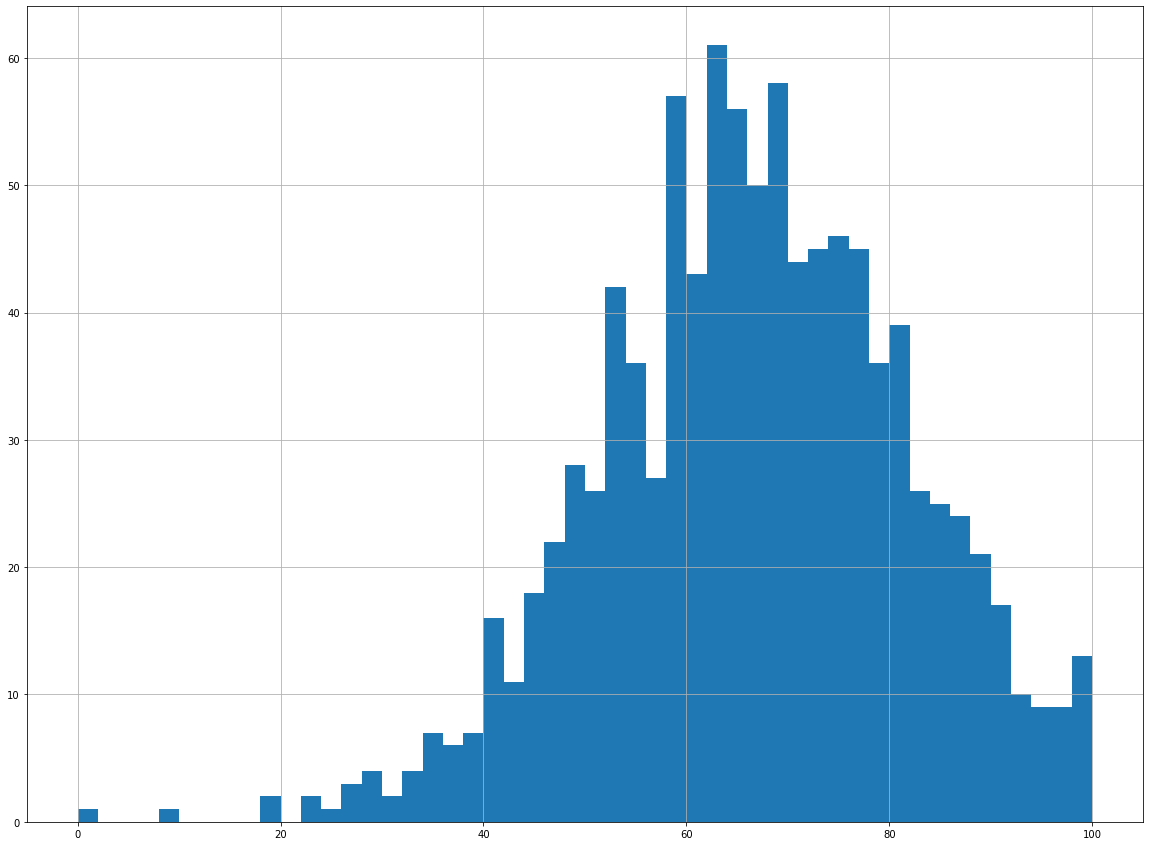

In [5]:
sdata["math score"].hist(bins=50, figsize=(20,15))
plt.show()

Histogram has more traffic toward the 60-80 x-axis values.

In [6]:
correlation = sdata.corr()
correlation["math score"].sort_values(ascending=False)

math score       1.000000
reading score    0.817580
writing score    0.802642
Name: math score, dtype: float64

Math score has the highest correlation out of the scores, with math score. 

In [7]:
from sklearn.preprocessing import OneHotEncoder

en = OneHotEncoder(handle_unknown="ignore")
en_temp = pd.DataFrame(en.fit_transform(sdata[["gender"]]).toarray())
en_temp.columns = en.get_feature_names_out(["gender"])
sdata.drop(["gender"],axis=1,inplace=True)
sdata = sdata.join(en_temp)


en_temp = pd.DataFrame(en.fit_transform(sdata[["race/ethnicity"]]).toarray())
en_temp.columns = en.get_feature_names_out(["race/ethnicity"])
sdata.drop(["race/ethnicity"],axis=1,inplace=True)
sdata = sdata.join(en_temp)



en_temp = pd.DataFrame(en.fit_transform(sdata[["test preparation course"]]).toarray())
en_temp.columns = en.get_feature_names_out(["test preparation course"])
sdata.drop(["test preparation course"],axis=1,inplace=True)
sdata = sdata.join(en_temp)

en_temp = pd.DataFrame(en.fit_transform(sdata[["lunch"]]).toarray())
en_temp.columns = en.get_feature_names_out(["lunch"])
sdata.drop(["lunch"],axis=1,inplace=True)
sdata = sdata.join(en_temp)

sdata["parental level of education"] = sdata["parental level of education"].replace('some high school',1)
sdata["parental level of education"] = sdata["parental level of education"].replace('high school',2)
sdata["parental level of education"] = sdata["parental level of education"].replace('some college',3)
sdata["parental level of education"] = sdata["parental level of education"].replace("associate's degree", 4)
sdata["parental level of education"] = sdata["parental level of education"].replace("bachelor's degree" ,5)
sdata["parental level of education"] = sdata["parental level of education"].replace("master's degree",6)





We change our categorical data into numerical/regressional data using a mixture of one-hot and ordinal encoding. One-hot requires creating a new field containing 1 or 0 for each unique value in a column. Ordinal simply replaces the value with an integer.

In [8]:
sdata.loc[[0]]

,parental level of education,math score,reading score,writing score,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,test preparation course_completed,test preparation course_none,lunch_free/reduced,lunch_standard
0,5,72,72,74,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [9]:
sdata["average score"] = (sdata["math score"] + sdata["reading score"] + sdata["writing score"])/3

In [10]:
sdata["binnedaverage"] = pd.qcut(sdata["average score"],4,retbins=False,labels=[1,2,3,4])
sdata["binned education"] = pd.cut(sdata["parental level of education"],4,retbins=False,labels=[1,2,3,4])






Binned the data as above, into 4 bins to segment the data. All the transformations for the data are now done for lab 2, we can now split into the test train split sets to be used in later labs. Also created average score that is exactly what it says, to represent the score data and see if we can draw correlations later on.

In [11]:
X_train,X_test, y_train, y_test = train_test_split(sdata[["math score"]], sdata["writing score"], random_state=0)


# LAB 3

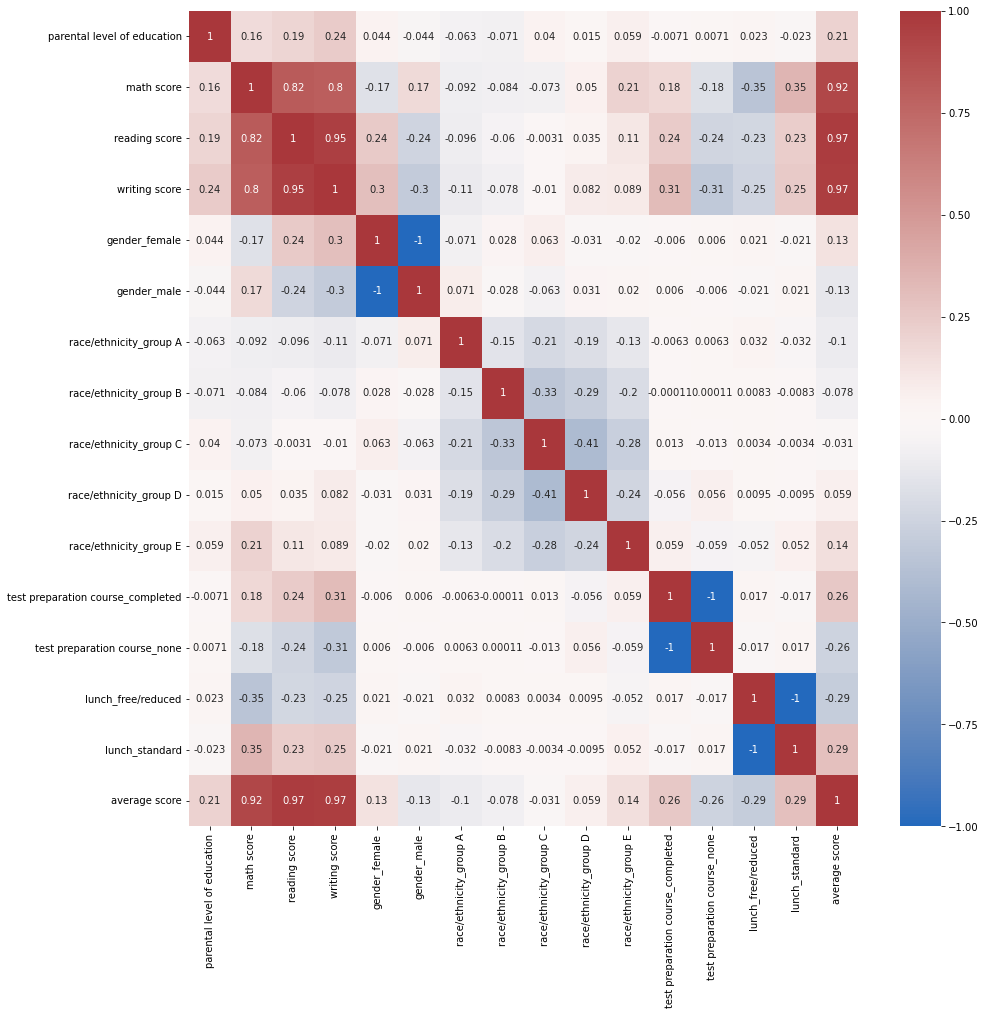

In [12]:
import seaborn as sns 

corr_matrix = sdata.corr(method='pearson')

fig, ax = plt.subplots(figsize=(15,15))

sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', ax=ax)
plt.show()

In [13]:
for x in sdata.columns:
         
    print(x+" coefficient",sdata["math score"].corr(sdata[x],method="pearson"))

#Correlations for math score

parental level of education coefficient 0.159431818157356
math score coefficient 1.0
reading score coefficient 0.8175796636720539
writing score coefficient 0.802642045949808
gender_female coefficient -0.16798223810035579
gender_male coefficient 0.16798223810035579
race/ethnicity_group A coefficient -0.09197709990214445
race/ethnicity_group B coefficient -0.08425005999398143
race/ethnicity_group C coefficient -0.07338687290137136
race/ethnicity_group D coefficient 0.05007071350889431
race/ethnicity_group E coefficient 0.2058545809467559
test preparation course_completed coefficient 0.17770246930439465
test preparation course_none coefficient -0.17770246930439465
lunch_free/reduced coefficient -0.35087664559186066
lunch_standard coefficient 0.35087664559186066
average score coefficient 0.9187457588383446
binnedaverage coefficient 0.8468000042339838
binned education coefficient 0.16705435775894198


In [14]:
for x in sdata.columns:
         
    print(x+" coefficient",sdata["binnedaverage"].corr(sdata[x],method="pearson"))

#Correlations for math score

parental level of education coefficient 0.17043337982657608
math score coefficient 0.8468000042339839
reading score coefficient 0.8987218702983271
writing score coefficient 0.8927429852768195
gender_female coefficient 0.12598713900125424
gender_male coefficient -0.12598713900125424
race/ethnicity_group A coefficient -0.11169418058253316
race/ethnicity_group B coefficient -0.06197448308580447
race/ethnicity_group C coefficient -0.03560814359017749
race/ethnicity_group D coefficient 0.06353283228579247
race/ethnicity_group E coefficient 0.12904403317736873
test preparation course_completed coefficient 0.2364187292338426
test preparation course_none coefficient -0.2364187292338426
lunch_free/reduced coefficient -0.26122082793757184
lunch_standard coefficient 0.26122082793757184
average score coefficient 0.9241430064256797
binnedaverage coefficient 1.0
binned education coefficient 0.18008141799048955


In [15]:
for x in sdata.columns:
         
    print(x+" coefficient",sdata["binned education"].corr(sdata[x],method="pearson"))

#Correlations for math score

parental level of education coefficient 0.9660848264225537
math score coefficient 0.16705435775894198
reading score coefficient 0.20115548376964387
writing score coefficient 0.2477304365234047
gender_female coefficient 0.04428131095271093
gender_male coefficient -0.04428131095271093
race/ethnicity_group A coefficient -0.049621050724031224
race/ethnicity_group B coefficient -0.07070003809647513
race/ethnicity_group C coefficient 0.03602298338078856
race/ethnicity_group D coefficient 0.010795016882074314
race/ethnicity_group E coefficient 0.05858501771383127
test preparation course_completed coefficient 0.01677177618857262
test preparation course_none coefficient -0.01677177618857262
lunch_free/reduced coefficient 0.019782228541485196
lunch_standard coefficient -0.019782228541485196
average score coefficient 0.2158982227533705
binnedaverage coefficient 0.18008141799048957
binned education coefficient 1.0


Correlations have been found for binned averages and education, and math score. Will now split the data, into three data sets containing different features, of top correlation. I will create these datasets for the correlation with binned education.

In [16]:
two_feat = sdata[["writing score","reading score"]]
five_feat = sdata[["writing score","reading score","gender_female","gender_male","math score"]]
seven_feat = sdata[["writing score","reading score","gender_female","gender_male","math score","race/ethnicity_group B","race/ethnicity_group A"]]

Do some linear regression on the data to test them out, and the output. Will check accuracy.


In [17]:
linear = LinearRegression()
linear.fit(X_train, y_train)


LinearRegression()

In [18]:
# Check the accuracy of the LinearRegression model.
lineardata = pd.DataFrame(linear.predict(X_train))
lineardata['target'] = y_train

linear.score(X_test, y_test) 

0.6037518291346904

In [19]:
X_train2,X_test2, y_train2, y_test2 = train_test_split(sdata[["math score"]], two_feat, random_state=0)
X_train3,X_test3, y_train3, y_test3 = train_test_split(sdata[["math score"]], five_feat, random_state=0)
X_train4,X_test4, y_train4, y_test4 = train_test_split(sdata[["math score"]], seven_feat, random_state=0)


In [25]:
linear.fit(X_train2, y_train2)


LinearRegression()

In [28]:
lineardata2 = pd.DataFrame(linear.predict(X_train2))
linear.score(X_test2, y_test2) 

0.607219491772258

In [29]:
linear.fit(X_train3, y_train3)

LinearRegression()

In [30]:
lineardata3 = pd.DataFrame(linear.predict(X_train3))
linear.score(X_test3, y_test3)

0.464641067966288

In [31]:
linear.fit(X_train4, y_train4)

LinearRegression()

In [32]:
lineardata4 = pd.DataFrame(linear.predict(X_train4))
linear.score(X_test4, y_test4)

0.33232286390574817

As a result, we can see the linear regression classifier is performing better on the two_feat dataset, with two features and has a better accuracy than just with the math score and writing fields.

# LAB 4

In [130]:
X_train,X_test, y_train, y_test = train_test_split(sdata[["math score"]], sdata["binnedaverage"], random_state=0)


pipe = Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier())])
# The pipeline can be used as any other estimator
 # and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)
Pipeline(steps=[('scaler', StandardScaler()), ('model', KNeighborsClassifier())])
print(pipe.score(X_test, y_test))








model = KNeighborsClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

cvs = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
print(cvs)



y_train_pred = cross_val_predict(model, X_train, y_train, cv=3)



confuse = confusion_matrix(y_train,y_train_pred)

confusePlot = ConfusionMatrixDisplay(confuse)


print(confuse)

print(classification_report(y_train,y_train_pred))


0.596
[0.672 0.676 0.632]
[[164  24   2   0]
 [ 57  70  51   2]
 [  6  35 115  31]
 [  0   7  40 146]]
              precision    recall  f1-score   support

           1       0.72      0.86      0.79       190
           2       0.51      0.39      0.44       180
           3       0.55      0.61      0.58       187
           4       0.82      0.76      0.78       193

    accuracy                           0.66       750
   macro avg       0.65      0.66      0.65       750
weighted avg       0.65      0.66      0.65       750



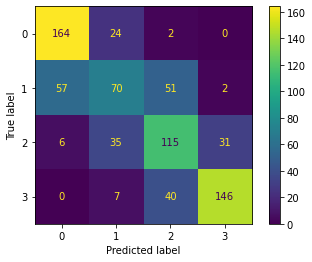

In [47]:

confusePlot.plot()

In [63]:
FP = confuse.sum(axis=0) - np.diag(confuse)  
FN = confuse.sum(axis=1) - np.diag(confuse)
TP = np.diag(confuse)
TN = confuse.sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
precision_score(y_test, y_pred,average='micro')
recall_score(y_test, y_pred,average='micro')
print(TPR,FPR)


[0.86315789 0.38888889 0.61497326 0.75647668] [0.1125     0.11578947 0.1651865  0.05924596]


As we construct the confusion matrix and get to see the false positive and false negative values, we get to see a visual representation of the accuracy of our classifier. We now check the ROC curve to match this. We see all the appropriate statistics required, above.


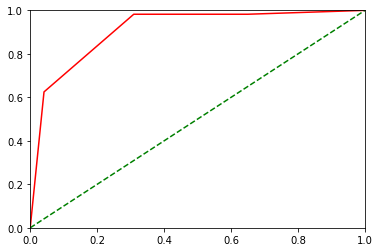

In [49]:

fpr,tpr,threshold = roc_curve(y_test,y_pred,pos_label=4)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,'r')
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'g--')
plt.show()

As this follows the traditional shape of the ROC curve, it means our classifier is of an appropriate accuracy and is working atleast as intended.

# LAB 5

In [131]:

bayes = MultinomialNB(alpha=1.0, fit_prior=False)
bayes.fit(X_train, y_train)
bayesPred = bayes.predict(X_test)
print(classification_report(y_test,bayesPred))


              precision    recall  f1-score   support

           1       0.26      1.00      0.42        66
           2       0.00      0.00      0.00        66
           3       0.00      0.00      0.00        62
           4       0.00      0.00      0.00        56

    accuracy                           0.26       250
   macro avg       0.07      0.25      0.10       250
weighted avg       0.07      0.26      0.11       250



E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


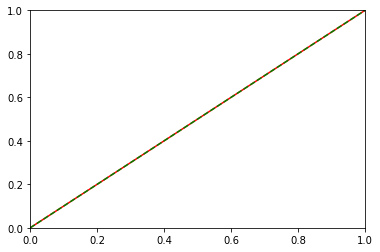

In [132]:
fpr,tpr,threshold = roc_curve(y_test,bayesPred,pos_label=4)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,'r')
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'g--')
plt.show()

We will also try the bernoulli and gaussian for the extra marks.

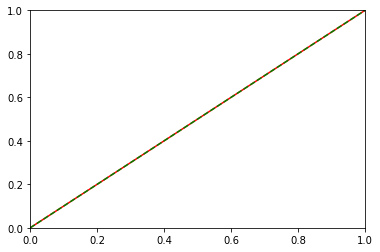

In [133]:
bayes2 = BernoulliNB(alpha=1.0, fit_prior=False)
bayes2.fit(X_train, y_train)
bayesPred2 = bayes.predict(X_test)
fpr,tpr,threshold = roc_curve(y_test,bayesPred2,pos_label=4)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,'r')
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'g--')
plt.show()

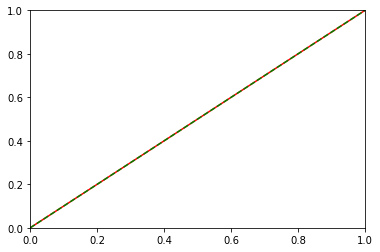

In [136]:
bayes2 = GaussianNB()
bayes2.fit(X_train, y_train)
bayesPred2 = bayes.predict(X_test)
fpr,tpr,threshold = roc_curve(y_test,bayesPred2,pos_label=4)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,'r')
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'g--')
plt.show()

All naive bayes, gaussian and even bernoulli give the same roc_curve and seem to be not working as intended, perhaps a problem with the data fed in.

# LAB 6


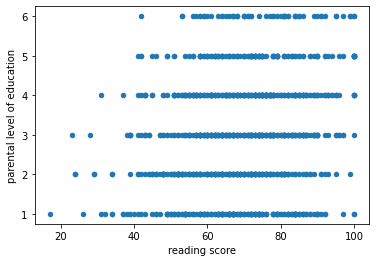

In [173]:
sdata.plot(x='reading score', y='parental level of education', kind='scatter')
X_k_means = sdata[['reading score', 'parental level of education']].to_numpy()
X_train, X_test= train_test_split(X_k_means)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
ypred = kmeans.fit_predict(X_train)

In [174]:
ypred

array([4, 0, 1, 3, 2, 4, 1, 4, 1, 0, 4, 0, 4, 1, 1, 0, 4, 0, 3, 2, 4, 0,
       4, 1, 2, 0, 2, 0, 2, 2, 2, 1, 0, 0, 0, 2, 4, 0, 4, 4, 2, 0, 4, 1,
       2, 1, 1, 1, 2, 4, 2, 1, 1, 4, 4, 2, 2, 0, 2, 4, 0, 2, 2, 4, 4, 4,
       3, 4, 2, 1, 2, 4, 4, 0, 4, 0, 4, 0, 2, 1, 3, 2, 2, 3, 2, 4, 1, 0,
       0, 1, 1, 2, 0, 0, 4, 2, 3, 0, 3, 1, 0, 2, 0, 1, 4, 0, 2, 3, 1, 1,
       4, 0, 1, 2, 3, 3, 2, 4, 2, 1, 0, 4, 0, 2, 1, 2, 1, 2, 1, 2, 4, 4,
       1, 4, 2, 0, 1, 4, 4, 4, 4, 0, 3, 2, 1, 2, 4, 4, 1, 2, 4, 0, 2, 4,
       4, 2, 0, 2, 4, 1, 0, 4, 1, 0, 1, 4, 3, 1, 0, 1, 0, 1, 0, 3, 2, 4,
       2, 2, 4, 2, 3, 2, 4, 4, 2, 2, 4, 2, 1, 4, 4, 4, 3, 4, 0, 1, 2, 2,
       3, 0, 1, 2, 0, 2, 3, 2, 3, 2, 1, 4, 4, 0, 1, 2, 2, 1, 4, 2, 1, 2,
       4, 4, 1, 4, 4, 2, 1, 0, 1, 0, 2, 1, 0, 4, 3, 3, 0, 4, 0, 2, 0, 0,
       1, 3, 0, 4, 3, 4, 1, 1, 2, 0, 4, 2, 4, 0, 2, 2, 2, 3, 1, 2, 0, 4,
       1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 3, 0, 4, 1, 1, 4, 2, 1, 2, 0, 1, 3,
       2, 2, 4, 0, 4, 4, 3, 2, 4, 4, 1, 1, 0, 4, 4,

In [175]:
kmeans.labels_

array([4, 0, 1, 3, 2, 4, 1, 4, 1, 0, 4, 0, 4, 1, 1, 0, 4, 0, 3, 2, 4, 0,
       4, 1, 2, 0, 2, 0, 2, 2, 2, 1, 0, 0, 0, 2, 4, 0, 4, 4, 2, 0, 4, 1,
       2, 1, 1, 1, 2, 4, 2, 1, 1, 4, 4, 2, 2, 0, 2, 4, 0, 2, 2, 4, 4, 4,
       3, 4, 2, 1, 2, 4, 4, 0, 4, 0, 4, 0, 2, 1, 3, 2, 2, 3, 2, 4, 1, 0,
       0, 1, 1, 2, 0, 0, 4, 2, 3, 0, 3, 1, 0, 2, 0, 1, 4, 0, 2, 3, 1, 1,
       4, 0, 1, 2, 3, 3, 2, 4, 2, 1, 0, 4, 0, 2, 1, 2, 1, 2, 1, 2, 4, 4,
       1, 4, 2, 0, 1, 4, 4, 4, 4, 0, 3, 2, 1, 2, 4, 4, 1, 2, 4, 0, 2, 4,
       4, 2, 0, 2, 4, 1, 0, 4, 1, 0, 1, 4, 3, 1, 0, 1, 0, 1, 0, 3, 2, 4,
       2, 2, 4, 2, 3, 2, 4, 4, 2, 2, 4, 2, 1, 4, 4, 4, 3, 4, 0, 1, 2, 2,
       3, 0, 1, 2, 0, 2, 3, 2, 3, 2, 1, 4, 4, 0, 1, 2, 2, 1, 4, 2, 1, 2,
       4, 4, 1, 4, 4, 2, 1, 0, 1, 0, 2, 1, 0, 4, 3, 3, 0, 4, 0, 2, 0, 0,
       1, 3, 0, 4, 3, 4, 1, 1, 2, 0, 4, 2, 4, 0, 2, 2, 2, 3, 1, 2, 0, 4,
       1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 3, 0, 4, 1, 1, 4, 2, 1, 2, 0, 1, 3,
       2, 2, 4, 0, 4, 4, 3, 2, 4, 4, 1, 1, 0, 4, 4,

In [176]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

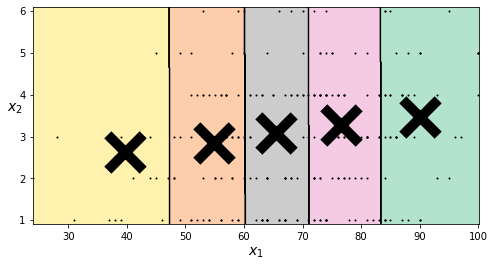

In [177]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X_test)
plt.show()

In [179]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X_test)
kmeans_iter2.fit(X_test)
kmeans_iter3.fit(X_test)

E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=1)

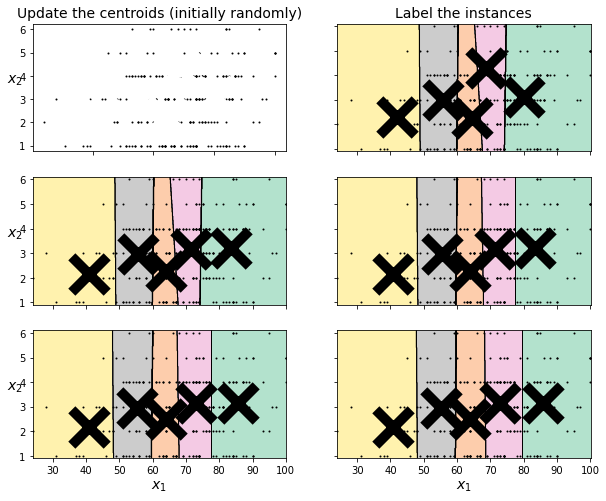

In [181]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X_test)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X_test, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X_test, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X_test, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X_test, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X_test, show_ylabels=False)

plt.show()